In [1]:
from nariflow import start_initializer

In [2]:
start_initializer().initializer('tape')

In [3]:
from nariflow import Variable
from nariflow import optimizer
from nariflow import GradientTape
#from nariflow import calc_gradient
from nariflow import layer
from nariflow.models import Model
from nariflow import functions as f
from nariflow.core import elementary_function as ef
from nariflow.core import shape_function as sf
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

import time

In [4]:
import os

dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\User\\.keras\\datasets\\auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset = dataset.dropna()

In [7]:
origin = dataset.pop('Origin')

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
normed_train_data

,Acceleration,Cylinders,Displacement,Europe,Horsepower,Japan,MPG,Model Year,USA,Weight
146,-0.379759,-0.869348,-1.009459,-0.465148,-0.784052,-0.495225,NaN,-0.516397,0.774676,-1.025303
282,0.624102,-0.869348,-0.530218,-0.465148,-0.442811,-0.495225,NaN,0.843910,0.774676,-0.118796
69,-0.738281,1.483887,1.482595,-0.465148,1.447140,-0.495225,NaN,-1.060519,0.774676,1.736877
378,-0.308055,-0.869348,-0.865687,-0.465148,-1.099044,-0.495225,NaN,1.660094,0.774676,-1.025303
331,0.875068,-0.869348,-0.942365,-0.465148,-0.994047,2.012852,NaN,1.115971,-1.286751,-1.001603
...,...,...,...,...,...,...,...,...,...,...
281,0.946772,0.307270,0.044872,-0.465148,-0.521559,-0.495225,NaN,0.843910,0.774676,-0.000298
229,-1.598734,1.483887,1.961837,-0.465148,1.972127,-0.495225,NaN,0.299787,0.774676,1.457223
150,-0.021237,-0.869348,-0.836932,-0.465148,-0.311564,2.012852,NaN,-0.516397,-1.286751,-0.710099
145,1.233589,-0.869348,-1.076553,-0.465148,-1.151543,2.012852,NaN,-0.516397,-1.286751,-1.169870


In [14]:
train_labels = train_dataset.pop('MPG')

In [15]:
X = Variable(np.array(normed_train_data.drop('MPG',axis = 1)))

In [16]:
y = (np.array(train_labels) - np.mean(np.array(train_dataset))) / np.std(np.array(train_dataset))

In [17]:
y = Variable(np.array(y).reshape([-1,1]))

In [18]:
lr = 0.2
max_iter = 10000
hidden_size = 200

In [19]:
class Models(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = layer.Linear(hidden_size, initializer_func='he_uniform')
        self.l2 = layer.Linear(hidden_size, initializer_func='he_uniform')
        self.l3 = layer.Linear(out_size, initializer_func='he_uniform')
        
    def forward(self, x):
        y = self.l1(x)
        y = f.activation.relu(y)
        y = self.l2(y)
        y = f.activation.relu(y)
        y = self.l3(y)
        return y

## Tape Gradient 실험

In [20]:
model = Models(100, 1)

optimizers = optimizer.Adam()

optimizers.setup(model)

In [21]:
start_time = time.time()
for i in range(10000):
    with GradientTape() as tape:
        y_pred = model(X)
        
        loss = f.loss.mean_squared_error(y, y_pred)
        
    tape.CalcGradient()
    
    optimizers.update()
    
    if i % 1000 == 0:
        print(loss.data)

print('total_time : ', time.time() - start_time)

0.13304978725976593
4.985433735413925e-06
3.731902959209638e-06
2.863333873544032e-06
2.208847885124663e-06
6.3042214129729985e-06
1.421449576173178e-06
1.9781000672181805e-06
1.6758052306226088e-06
1.096315160711311e-06
total_time :  13.254669904708862


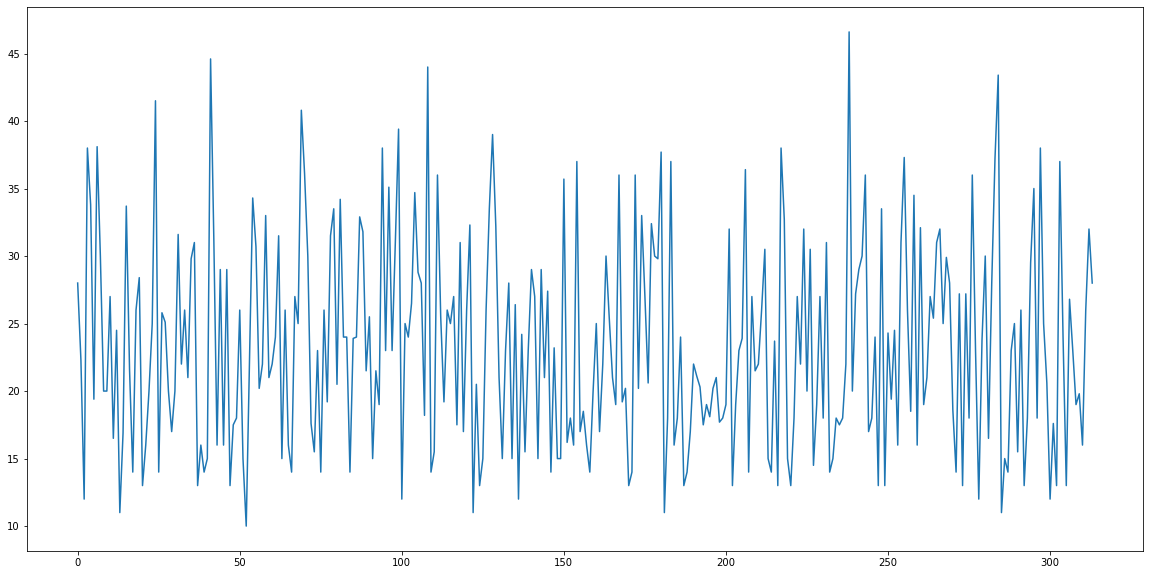

In [22]:
plt.figure(figsize = (20,10))
plt.plot(y.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'real')

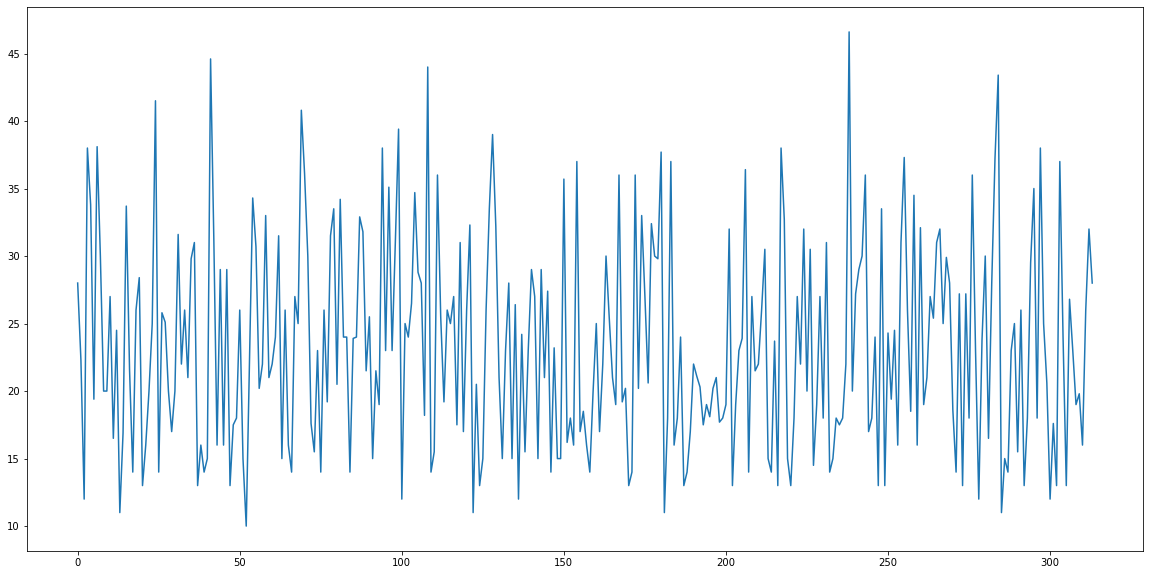

In [23]:
plt.figure(figsize = (20,10))
plt.plot(y.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'real')

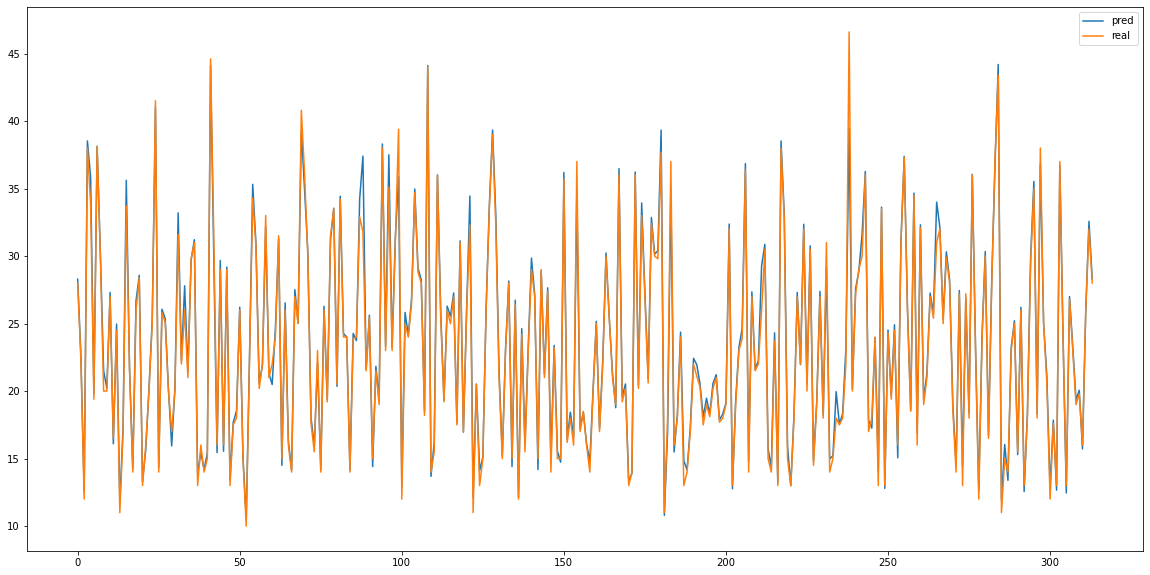

In [24]:
plt.figure(figsize = (20,10))
plt.plot(y_pred.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'pred')
plt.plot(y.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'real')
plt.legend()

## Node 실험

In [21]:
model = Models(100, 1)

optimizers = optimizer.SGD()

optimizers.setup(model)

In [22]:
start_time = time.time()
for i in range(10000):
    
    y_pred = model(X)

    loss = f.loss.mean_squared_error(y, y_pred)

    calc_gradient([loss])
    
    optimizers.update()
    
    if i % 1000 == 0:
        print(loss.data)

print('total time :', time.time() - start_time)

0.13633998973949968
6.30082919968511e-05
4.31871597892013e-05
3.2715162399790455e-05
2.647681879070653e-05
2.2480632074853786e-05
1.9790531581453405e-05
1.791828788678521e-05
1.6556744984993453e-05
1.5514224059796942e-05
total time : 86.43109321594238


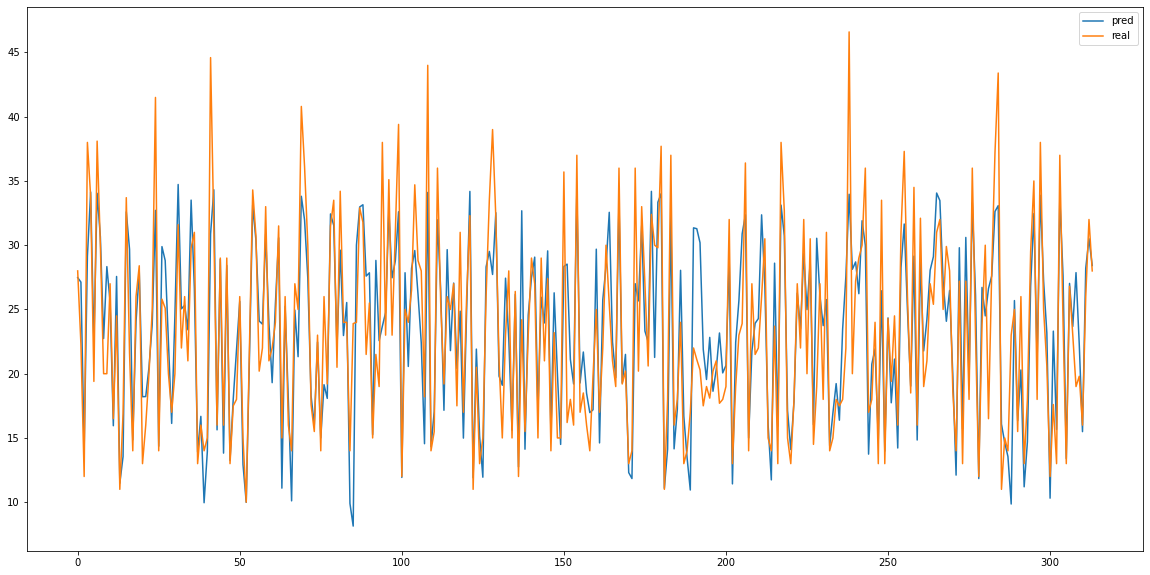

In [22]:
plt.figure(figsize = (20,10))
plt.plot(y_pred.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'pred')
plt.plot(y.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'real')
plt.legend()

## 결론
### 1. TapeGradient 방식은 Node Chain 방식에 비해 약 2.5배 빠르다
### 2. 성능상의 차이는 없다.
### 3. 따라서, TapeGradient를 활용하는 것을 추천한다.

## Loss 두개 동시 전파 실험

In [27]:
model = Models(100, 1)

optimizers = optimizer.SGD()

optimizers.setup(model)

In [28]:
start_time = time.time()
for i in range(10000):
    with GradientTape() as tape:
        y_pred_1 = model(X)
        y_pred_2 = model(X)
        
        loss_1 = f.loss.mean_squared_error(y, y_pred_1)
        loss_2 = f.loss.mean_squared_error(y, y_pred_2)
        
    tape.CalcGradient()
    
    optimizers.update()
    
    if i % 1000 == 0:
        print(loss_1.data)

print(time.time() - start_time)

0.1323079376498324
4.7593071099752445e-05
2.927564813631283e-05
2.251825549614693e-05
1.9025915589227446e-05
1.6873175749174392e-05
1.5404905552077592e-05
1.433362400257478e-05
1.3498299443197443e-05
1.2823903011919244e-05
33.06233811378479


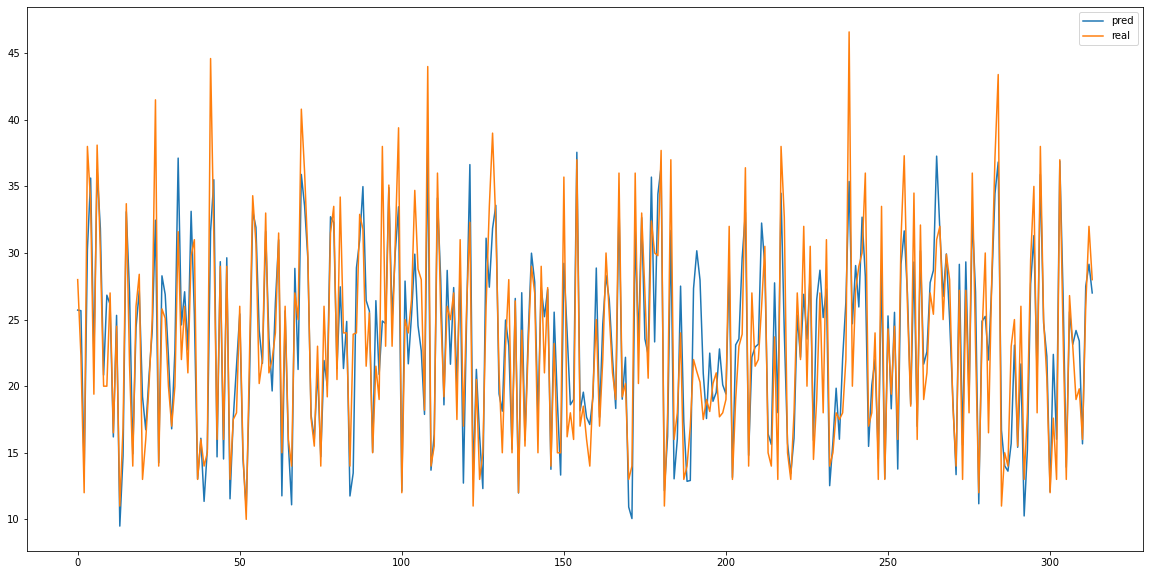

In [29]:
plt.figure(figsize = (20,10))
plt.plot(y_pred_1.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'pred')
plt.plot(y.data.reshape([-1]) * np.std(np.array(train_dataset)) + np.mean(np.array(train_dataset)),
        label = 'real')
plt.legend()

### 결론
#### 1. TapeGradient 모드에서 두개 로스 동시 역전파도 가능하다

# 1차 미분 테스트

In [30]:
def goldstein(x,y):
    z = (1 + (x + y + 1) ** 2 * (19 - 14 * x + 3 * x **2 - 14 * y + 6 * x * y + 3 * y ** 2)) * \
    (30 + (2 * x - 3 * y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    
    return z

In [31]:
def matyas(x, y):
    z = 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
    return z

In [32]:
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))

In [33]:
with GradientTape() as tape:
    z = goldstein(x,y)

In [34]:
tape.CalcGradient()

정답은 x미분 -5376, y미분 8064이다.

In [35]:
print(x.grad.data) 
print(y.grad.data)

-5376.0
8064.0


In [36]:
tape.resetgrads()

In [37]:
with GradientTape() as tape:
    z = matyas(x,y)

In [38]:
tape.CalcGradient()

정답은 x미분, y미분 0.04이다.

In [33]:
print(x.grad.data)
print(y.grad.data)

0.040000000000000036
0.040000000000000036


### 결론 : 복잡한 함수에 대하여도 미분이 잘 수행된다. 

# 고계 미분 테스트

In [25]:
x = Variable(np.array(2.0))
y = Variable(np.array(2.0))

In [26]:
# 함수 정의
def function(x,y):
    z = x ** 4 + y ** 3 + x ** 2 + y ** (1/2)
    return z

#### 2차 미분
dx^2 = 12 * x + 2

dy^2 = 6y + (-1 / (4*y^(3/2)))

In [27]:
with GradientTape() as tape:
    f = function(x,y)

In [28]:
with GradientTape() as tape_2:
    tape.CalcGradient()

In [29]:
# resetgrad를 반드시 수행해야 한다.
tape.resetgrads()

In [30]:
tape_2.CalcGradient()

X 2차미분 정작 : 50

In [31]:
x.grad.data

array(50.)

Y 2차미분 정답 : 11.911

In [32]:
y.grad.data

array(11.91161165)

### 결론 : 2계 이상의 고계 미분에서도 잘 작동한다.

## 행렬 고계 미분 테스트

In [47]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))

### - 행렬 X애 대한 고계 미분 테스트

In [48]:
def f(x):
    y = 2 * x ** 3
    return y

In [49]:
with GradientTape() as tape:
    result = f(X)

In [50]:
result.data

array([[  2.,  16.],
       [128., 250.]])

In [51]:
with GradientTape() as tape_2:
    tape.CalcGradient()

### 1계 미분 시, 2 * x ^ 3 => 6 * x ^ 2가 된다.
### 이 때, 각 성분은 각각 [[6, 24], [96, 150]]이 나와야 한다

In [47]:
# 정답

X.grad.data

array([[  6.,  24.],
       [ 96., 150.]])

### 2계 미분 시, 6 * x ^ 2 => 12 * x가 된다.
### 이 때, 각 성분은 각각 [[12, 24], [48, 60]]이 나와야 한다

In [48]:
tape.resetgrads()
with GradientTape() as tape_3:
    tape_2.CalcGradient()

In [49]:
# 정답

X.grad.data

array([[12., 24.],
       [48., 60.]])

### 3계 미분 시, 12 * x => 12가 된다.
### 이 때, 각 성분은 각각 [[12,12], [12, 12]]이 나와야 한다

In [50]:
tape_2.resetgrads()
tape_3.CalcGradient()

In [51]:
# 정답

X.grad.data

array([[12., 12.],
       [12., 12.]])

### 결론 : 행렬에 대한 고계 미분도 문제 없이 수행한다.

## 행렬 연산에 대한 야코비 행렬 테스트

#### - 텐서플로우와의 미분 결과 비교를 통해 적정성을 판단한다.

#### 1) matmul

In [59]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [60]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)

In [61]:
tape.jacobian(result_2, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 1.,  2.],
         [ 4.,  8.]],

        [[ 3.,  6.],
         [ 6., 12.]]],


       [[[ 4.,  5.],
         [16., 20.]],

        [[12., 15.],
         [24., 30.]]]])>

In [46]:
tape.jacobian(result_2, k)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[14.,  0.],
         [20.,  0.]],

        [[ 0., 14.],
         [ 0., 20.]]],


       [[[41.,  0.],
         [59.,  0.]],

        [[ 0., 41.],
         [ 0., 59.]]]])>

In [49]:
tape.jacobian(result, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[4., 5.],
         [0., 0.]],

        [[6., 7.],
         [0., 0.]]],


       [[[0., 0.],
         [4., 5.]],

        [[0., 0.],
         [6., 7.]]]])>

In [55]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [56]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)

In [57]:
tape.jacobian(var = X, var_return='numpy')

array([[[28., 33.],
        [ 0.,  0.]],

       [[48., 57.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [28., 33.]],

       [[ 0.,  0.],
        [48., 57.]]])

In [60]:
tape.jacobian(var = X, var_return='numpy')

array([[[28., 33.],
        [ 0.,  0.]],

       [[48., 57.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [28., 33.]],

       [[ 0.,  0.],
        [48., 57.]]])

In [61]:
tape.jacobian(var = v, var_return='numpy')

array([[[ 1.,  2.],
        [ 4.,  8.]],

       [[ 3.,  6.],
        [ 6., 12.]],

       [[ 4.,  5.],
        [16., 20.]],

       [[12., 15.],
        [24., 30.]]])

In [62]:
tape.jacobian(var = k, var_return='numpy')

array([[[14.,  0.],
        [20.,  0.]],

       [[ 0., 14.],
        [ 0., 20.]],

       [[41.,  0.],
        [59.,  0.]],

       [[ 0., 41.],
        [ 0., 59.]]])

In [63]:
tape.jacobian(target = result, var = X, var_return='numpy')

array([[[4., 5.],
        [0., 0.]],

       [[6., 7.],
        [0., 0.]],

       [[0., 0.],
        [4., 5.]],

       [[0., 0.],
        [6., 7.]]])

### 2) reduce_sum

In [64]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [71]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)
    result_3 = tf.math.reduce_sum(result_2)

In [66]:
tape.jacobian(result_3, x)

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[76., 90.],
       [76., 90.]])>

In [69]:
tape.jacobian(result_3, v)

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[20., 28.],
       [50., 70.]])>

In [14]:
tape.jacobian(result_2,x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[28., 33.],
         [ 0.,  0.]],

        [[48., 57.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [28., 33.]],

        [[ 0.,  0.],
         [48., 57.]]]])>

In [72]:
tape.jacobian(result_2,v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 1.,  2.],
         [ 4.,  8.]],

        [[ 3.,  6.],
         [ 6., 12.]]],


       [[[ 4.,  5.],
         [16., 20.]],

        [[12., 15.],
         [24., 30.]]]])>

In [73]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [74]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)
    result_3 = ef.flowsum(result_2)

In [75]:
tape.jacobian(var = X, var_return='numpy')

array([[[76., 90.],
        [76., 90.]]])

In [60]:
tape.jacobian(var = v, var_return='numpy')

array([[[20., 28.],
        [50., 70.]]])

In [28]:
tape.jacobian(target = result_2, var = X, var_return='numpy')

array([[[28., 33.],
        [ 0.,  0.]],

       [[48., 57.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [28., 33.]],

       [[ 0.,  0.],
        [48., 57.]]])

In [29]:
tape.jacobian(target = result_2, var = v, var_return='numpy')

array([[[ 1.,  2.],
        [ 4.,  8.]],

       [[ 3.,  6.],
        [ 6., 12.]],

       [[ 4.,  5.],
        [16., 20.]],

       [[12., 15.],
        [24., 30.]]])

### 3) div

In [73]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [81]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)
    result_3 = result_2 / result

In [32]:
tape.jacobian(result_3, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 0.08163265, -0.04081633],
         [ 0.        ,  0.        ]],

        [[-0.03      ,  0.015     ],
         [ 0.        ,  0.        ]]],


       [[[ 0.        ,  0.        ],
         [ 0.02379536, -0.01903629]],

        [[ 0.        ,  0.        ],
         [-0.00861821,  0.00689457]]]])>

In [35]:
tape.jacobian(result_3, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[-0.40816327, -0.81632653],
         [ 0.28571429,  0.57142857]],

        [[ 0.15      ,  0.3       ],
         [-0.105     , -0.21      ]]],


       [[[-0.56157049, -0.70196312],
         [ 0.3902439 ,  0.48780488]],

        [[ 0.20338983,  0.25423729],
         [-0.1413387 , -0.17667337]]]])>

In [80]:
tape.jacobian(result_2, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[28., 33.],
         [ 0.,  0.]],

        [[48., 57.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [28., 33.]],

        [[ 0.,  0.],
         [48., 57.]]]])>

In [82]:
tape.jacobian(result_2, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 1.,  2.],
         [ 4.,  8.]],

        [[ 3.,  6.],
         [ 6., 12.]]],


       [[[ 4.,  5.],
         [16., 20.]],

        [[12., 15.],
         [24., 30.]]]])>

In [45]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [46]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)
    result_3 = result_2 / result

In [47]:
tape.jacobian(var = X, var_return='numpy')

array([[[ 0.08163265, -0.04081633],
        [ 0.        ,  0.        ]],

       [[-0.03      ,  0.015     ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.02379536, -0.01903629]],

       [[ 0.        ,  0.        ],
        [-0.00861821,  0.00689457]]])

In [48]:
tape.jacobian(var = v, var_return='numpy')

array([[[-0.40816327, -0.81632653],
        [ 0.28571429,  0.57142857]],

       [[ 0.15      ,  0.3       ],
        [-0.105     , -0.21      ]],

       [[-0.56157049, -0.70196312],
        [ 0.3902439 ,  0.48780488]],

       [[ 0.20338983,  0.25423729],
        [-0.1413387 , -0.17667337]]])

In [49]:
tape.jacobian(target = result_2, var = X, var_return='numpy')

array([[[28., 33.],
        [ 0.,  0.]],

       [[48., 57.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [28., 33.]],

       [[ 0.,  0.],
        [48., 57.]]])

In [50]:
tape.jacobian(target = result_2, var = v, var_return='numpy')

array([[[ 1.,  2.],
        [ 4.,  8.]],

       [[ 3.,  6.],
        [ 6., 12.]],

       [[ 4.,  5.],
        [16., 20.]],

       [[12., 15.],
        [24., 30.]]])

### 4) sum

In [74]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [75]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)
    result_3 = result_2 + result

In [53]:
tape.jacobian(result_3, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[32., 38.],
         [ 0.,  0.]],

        [[54., 64.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [32., 38.]],

        [[ 0.,  0.],
         [54., 64.]]]])>

In [57]:
tape.jacobian(result_3, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 2.,  4.],
         [ 4.,  8.]],

        [[ 3.,  6.],
         [ 7., 14.]]],


       [[[ 8., 10.],
         [16., 20.]],

        [[12., 15.],
         [28., 35.]]]])>

In [73]:
tape.jacobian(result_2, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[28., 33.],
         [ 0.,  0.]],

        [[48., 57.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [28., 33.]],

        [[ 0.,  0.],
         [48., 57.]]]])>

In [76]:
tape.jacobian(result_2, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 1.,  2.],
         [ 4.,  8.]],

        [[ 3.,  6.],
         [ 6., 12.]]],


       [[[ 4.,  5.],
         [16., 20.]],

        [[12., 15.],
         [24., 30.]]]])>

In [78]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [79]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)
    result_3 = result_2 + result

In [80]:
tape.jacobian(var = X, var_return='numpy')

array([[[32., 38.],
        [ 0.,  0.]],

       [[54., 64.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [32., 38.]],

       [[ 0.,  0.],
        [54., 64.]]])

In [81]:
tape.jacobian(var = v, var_return='numpy')

array([[[ 2.,  4.],
        [ 4.,  8.]],

       [[ 3.,  6.],
        [ 7., 14.]],

       [[ 8., 10.],
        [16., 20.]],

       [[12., 15.],
        [28., 35.]]])

In [82]:
tape.jacobian(target = result_2, var = X, var_return='numpy')

array([[[28., 33.],
        [ 0.,  0.]],

       [[48., 57.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [28., 33.]],

       [[ 0.,  0.],
        [48., 57.]]])

In [83]:
tape.jacobian(target = result_2, var = v, var_return='numpy')

array([[[ 1.,  2.],
        [ 4.,  8.]],

       [[ 3.,  6.],
        [ 6., 12.]],

       [[ 4.,  5.],
        [16., 20.]],

       [[12., 15.],
        [24., 30.]]])

### 5) mul

In [94]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [95]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)
    result_3 = result_2 * result

In [86]:
tape.jacobian(result_3, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 768.,  932.],
         [   0.,    0.]],

        [[1932., 2274.],
         [   0.,    0.]]],


       [[[   0.,    0.],
         [2256., 2738.]],

        [[   0.,    0.],
         [5694., 6702.]]]])>

In [90]:
tape.jacobian(result_3, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 108.,  216.],
         [  56.,  112.]],

        [[  60.,  120.],
         [ 282.,  564.]]],


       [[[1272., 1590.],
         [ 656.,  820.]],

        [[ 708.,  885.],
         [3324., 4155.]]]])>

In [93]:
tape.jacobian(result_2, x)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[28., 33.],
         [ 0.,  0.]],

        [[48., 57.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [28., 33.]],

        [[ 0.,  0.],
         [48., 57.]]]])>

In [96]:
tape.jacobian(result_2, v)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float64, numpy=
array([[[[ 1.,  2.],
         [ 4.,  8.]],

        [[ 3.,  6.],
         [ 6., 12.]]],


       [[[ 4.,  5.],
         [16., 20.]],

        [[12., 15.],
         [24., 30.]]]])>

In [68]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [69]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)
    result_3 = result_2 * result

In [70]:
tape.jacobian(var = X, var_return='numpy')

array([[[ 768.,  932.],
        [   0.,    0.]],

       [[1932., 2274.],
        [   0.,    0.]],

       [[   0.,    0.],
        [2256., 2738.]],

       [[   0.,    0.],
        [5694., 6702.]]])

In [100]:
tape.jacobian(var = v, var_return='numpy')

array([[[ 108.,  216.],
        [  56.,  112.]],

       [[  60.,  120.],
        [ 282.,  564.]],

       [[1272., 1590.],
        [ 656.,  820.]],

       [[ 708.,  885.],
        [3324., 4155.]]])

In [101]:
tape.jacobian(target = result_2, var = X, var_return='numpy')

array([[[28., 33.],
        [ 0.,  0.]],

       [[48., 57.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [28., 33.]],

       [[ 0.,  0.],
        [48., 57.]]])

In [102]:
tape.jacobian(target = result_2, var = v, var_return='numpy')

array([[[ 1.,  2.],
        [ 4.,  8.]],

       [[ 3.,  6.],
        [ 6., 12.]],

       [[ 4.,  5.],
        [16., 20.]],

       [[12., 15.],
        [24., 30.]]])

### 결론 : 텐서플로우를 기준으로 놨을 때 야코비 행렬 연산도 문제없이 잘 수행한다.

# gradient 계산 시작지점 변경 테스트

- Tensorflow의 Tape Gradient와 nariflow의 Tape Gradient의 비교
- 그레디언트 계산 시작지점을 '중간 부터'로 설정하고, 계산 결과가 동일한지 비교한다

In [63]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [64]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)
    result_3 = result_2 / x

In [65]:
tape.gradient(result_2, [x, v])

[<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[76., 90.],
        [76., 90.]])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[20., 28.],
        [50., 70.]])>]

In [66]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [67]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)
    result_3 = result_2 / X

In [68]:
tape.CalcGradient(target = result_2)

In [69]:
X.grad.data

array([[76., 90.],
       [76., 90.]])

In [70]:
v.grad.data

array([[20., 28.],
       [50., 70.]])

In [96]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [97]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(result, k)
    result_2 = result_2 ** 2
    result_3 = result_2 * x

In [98]:
tape.gradient(result_2, [result_2, x, v])

[<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1., 1.],
        [1., 1.]])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[20816., 24672.],
        [61304., 72660.]])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[14824., 19400.],
        [34456., 45092.]])>]

In [99]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [100]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(result, k)
    result_2 = result_2 ** 2
    result_3 = result_2 * X

In [101]:
tape.CalcGradient(target = result_2)

In [102]:
result_2.grad.data

array([[1., 1.],
       [1., 1.]])

In [103]:
X.grad.data

array([[20816., 24672.],
       [61304., 72660.]])

In [104]:
v.grad.data

array([[14824., 19400.],
       [34456., 45092.]])

### 결론 : 텐서플로우를 기준으로 놨을 때 중간 Start 그레디언트 계산도 문제없이 수행한다.

# stop_gradient 테스트

- StopGradient는 Gradient를 0으로 바꾸어 흘려보낸다. 즉, 그레디언트 전파를 중단한다
- 이를 Tensorflow와 비교한다

In [123]:
x = tf.Variable(np.array([[1.,2.],[4.,5.]]))
v = tf.Variable(np.array([[4.,5.],[6.,7.]]))
k = tf.Variable(np.array([[1.,3.],[4.,6.]]))

In [124]:
with tf.GradientTape() as tape:
    result = tf.matmul(x,tf.transpose(v))
    result_2 = tf.matmul(tf.stop_gradient(result), k)
    result_2 = result_2 ** 2
    result_3 = result_2 * x

In [125]:
tape.gradient(result_3, [result_2, x, v, k])

[<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1., 2.],
        [4., 5.]])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[  8836.,  26244.],
        [ 76729., 227529.]])>,
 None,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[ 93488., 204642.],
        [134504., 294390.]])>]

In [116]:
X = Variable(np.array([[1.,2.],[4.,5.]]))
v = Variable(np.array([[4.,5.],[6.,7.]]))
k = Variable(np.array([[1.,3.],[4.,6.]]))

In [117]:
with GradientTape() as tape:
    result = ef.matmul(X,sf.transpose(v))
    result_2 = ef.matmul(ef.stop_gradient(result), k)
    result_2 = result_2 ** 2
    result_3 = result_2 * X

In [118]:
tape.CalcGradient(target = result_3)

In [119]:
result_2.grad.data

array([[1., 2.],
       [4., 5.]])

Gradient를 0으로 바꿔 흘려보낸다.

In [121]:
v.grad.data

array([[0., 0.],
       [0., 0.]])

In [122]:
k.grad.data

array([[ 93488., 204642.],
       [134504., 294390.]])